__Importing the required packages__

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import itertools
import time
import regex as re
import string
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
from PIL import Image
import spacy
import gensim
import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks
cufflinks.go_offline(connected=True)

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix,classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import pickle
import joblib

seed = 42
np.random.seed(seed)

import warnings
warnings.filterwarnings("ignore")

__Loading the dataset__

In [3]:
#!pip install openpyxl
df = pd.read_excel(r"D:\Msc in AI\NLP\BLOG GENDER BALANCED.xlsx", engine = "openpyxl")
df.head()

,BLOG,GENDER
0,Beyond Getting There: What Travel Days Show U...,F
1,I remember so much about the island; the large...,F
2,I have had asthma and allergies my entire life...,M
3,The last few days have been an emotional rolle...,M
4,If you lined up all the teachers and staff in ...,F


__Lets look at some random blog from the dataset__

In [4]:
df.iloc[9][0]

"One of those men was Mark Riddering. We barely knew him when he helped us move, but that didn't stop him from eagerly volunteering to help. As we got to know him...well, I have to admit that he sometimes made me feel like I did when I was a little girl and hero-worshiped a heroic policeman. Mark Riddering was a good cop. He was a true hero. He was also one of the sweetest, kindest men I've ever met. I loved watching him interact with his kids, loved watching how he looked at them, how he played with them, how he so obviously cherished them and his wife. He enjoyed life...enjoyed his family...enjoyed his many, many friends. I don't think I'll ever forget his smile or his laugh. We knew Mark during the time when he began noticing troubling symptoms, and when he received the diagnosis of ALS. He was an important part of the weekly Bible study that first met in his home and later in ours. We all watched him walk through this time of uncertainty. If he felt sorry for himself, we never knew

__Lets check who has written the above thread, either male or female__

In [5]:
df.iloc[9][1]

'F'

__Basic Dataset information__

In [6]:
print(df.info())
print("Shape of the Dataset is:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2599 entries, 0 to 2598
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   BLOG    2599 non-null   object
 1   GENDER  2599 non-null   object
dtypes: object(2)
memory usage: 40.7+ KB
None
Shape of the Dataset is: (2599, 2)


__Observation__

- The dataset has two columns namely Blog and Gender, there are 2599 records with no missing values.
- Both the columns are of object type.

__Distribution of Gender__

In [7]:
df.GENDER.value_counts()

F    1300
M    1299
Name: GENDER, dtype: int64

In [8]:
percentage = round(df.GENDER.value_counts(normalize=True).to_frame(name = "Percentage %").rename_axis("Gender")*100,2)
percentage

,Percentage %
Gender,
F,50.02
M,49.98


__Text Data Preprocessing__

Before we start with any NLP project, we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:

- Make text all __lowercase__ or __uppercase__ so that the algorithm does not treat the same words in different cases as different
- __Removing Noise__ i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)
- __Tokenization__: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
- __Stopword Removal__: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

__More data cleaning steps after tokenization:__

- __Stemming__: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
- __Lemmatization__: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
- Parts of speech tagging
- Create bi-grams or tri-grams And more...

However, it is not necessary that you would need to use all these steps. The usage depends on our problem statement at hand.

__Applying a first round of text cleaning techniques__

In [9]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [10]:
#Checking the text before cleaning
df.iloc[734][0]

'hiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii this is poo ///////////////////////// ok i m gfoinng to tell some thing about jaya (gayathiri) ok let me say sum lies abt her 1.she is a very good gal!!!!!!!!!!!!!! 2.quite gal !!!!!!!!!!!! 3. very bad in dancing then etc etc..................... okkkkkkkkkkkkkkk okkkk i think u feel like slaping me nw ................... to say abt jaya she is a very good dancer who always teach me the new dances which i dont knw and help me by clearing my douts............ist nt dddddddddddddd.......... she is a good friend for all of us but she like to talk a lot with my sister than meeeeeeeeeeee she is one of the rowdy in my dancing class....... i just love her eyes a lot........... i like her attitude tat she is always frist and i admire her way of dancing!!!!!!!!!!!!!!!! i like her soooooooooooooo much when she fight with person i dont like(i knw i m selfish) she loves to take photos wen ever v go out............... last but nt the least she is a multi talente

__Applying the cleaning function to the dataset__

In [11]:
df["BLOG"] = df["BLOG"].apply(lambda x: clean_text(x))

In [12]:
#Checking the text after cleaning
df.iloc[734][0]

'hiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii this is poo  ok i m gfoinng to tell some thing about jaya gayathiri ok let me say sum lies abt her  is a very good gal  gal   very bad in dancing then etc etc okkkkkkkkkkkkkkk okkkk i think u feel like slaping me nw  to say abt jaya she is a very good dancer who always teach me the new dances which i dont knw and help me by clearing my doutsist nt dddddddddddddd she is a good friend for all of us but she like to talk a lot with my sister than meeeeeeeeeeee she is one of the rowdy in my dancing class i just love her eyes a lot i like her attitude tat she is always frist and i admire her way of dancing i like her soooooooooooooo much when she fight with person i dont likei knw i m selfish she loves to take photos wen ever v go out last but nt the least she is a multi talented gallllllllllllll'

__Observation__

- There are some repetitive words and also some irregular words like hiiiiii, okkkkkk, meeeee which doesn't add any value to our analysis, so we can remove them.

In [13]:
def remove_repetitive_words(string):
    x = string.split()
    x = sorted(set(x), key = x.index)
    return ' '.join(x)

def remove_irregular_words(string):
    if (len(string)==0):
        return ''
    if (set(string) == set(string[0])):
        return ''    
    prev = None
    letters = [l for l in string]
    counter = 1
    new = []
    for l in letters:
        if l==prev:
            counter+=1
        else:
            if (counter==2):
                new.append(prev)
            counter=1
            new.append(l)
            prev = l
    return ''.join(new)

In [14]:
df["BLOG"] = df["BLOG"].apply(lambda x: remove_repetitive_words(x))
df["BLOG"] = df["BLOG"].apply(lambda x: remove_irregular_words(x))

In [15]:
df.iloc[734][0]

'hi this is poo ok i m gfoinng to tell some thing about jaya gayathiri let me say sum lies abt her a very good gal bad in dancing then etc ok ok think u feel like slaping nw she dancer who always teach the new dances which dont knw and help by clearing my doutsist nt d friend for all of us but talk lot with sister than me one rowdy class just love eyes attitude tat frist admire way so much when fight person likei selfish loves take photos wen ever v go out last least multi talented gal'

__Let's also remove the shorts words__

In [16]:
df["BLOG"] = df["BLOG"].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [17]:
df.iloc[734][0]

'this poo gfoinng tell some thing about jaya gayathiri let say sum lies abt her very good gal bad dancing then etc think feel like slaping she dancer who always teach the new dances which dont knw and help clearing doutsist friend for all but talk lot with sister than one rowdy class just love eyes attitude tat frist admire way much when fight person likei selfish loves take photos wen ever out last least multi talented gal'

__Tokenization__

- Tokenization is a process that splits an input sequence into so-called tokens where the tokens can be a word, sentence, paragraph etc. 

In [18]:
#Tokenizing the dataset
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
df["TOKENS"] =  df["BLOG"].apply(lambda x: tokenizer.tokenize(x))

In [19]:
df.head()

,BLOG,GENDER,TOKENS
0,beyond getting there what travel days show ust...,F,"[beyond, getting, there, what, travel, days, s..."
1,remember much about the island large lighthous...,F,"[remember, much, about, the, island, large, li..."
2,have had asthma and allergies entire life whil...,M,"[have, had, asthma, and, allergies, entire, li..."
3,the last few days have been emotional rollerco...,M,"[the, last, few, days, have, been, emotional, ..."
4,you lined all the teachers and staff school se...,F,"[you, lined, all, the, teachers, and, staff, s..."


__Stopwords Removal__

Now, let's get rid of the stopwords i.e words which occur very frequently but have no possible value like a, an, the, are etc. We can either use nltk corpus or our own customer built stopwords.

In [20]:
#Loading own custom stopwords for english language
custom_stopwords = open(r"D:\Msc in AI\NLP\CustomStopWordsEnglish.txt", encoding="utf8").read().split()
custom_stopwords

["'ll",
 "'tis",
 "'twas",
 "'ve",
 '10',
 '39',
 'a',
 "a's",
 'able',
 'ableabout',
 'about',
 'above',
 'abroad',
 'abst',
 'accordance',
 'according',
 'accordingly',
 'across',
 'act',
 'actually',
 'ad',
 'added',
 'adj',
 'adopted',
 'ae',
 'af',
 'affected',
 'affecting',
 'affects',
 'after',
 'afterwards',
 'ag',
 'again',
 'against',
 'ago',
 'ah',
 'ahead',
 'ai',
 "ain't",
 'aint',
 'al',
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'alongside',
 'already',
 'also',
 'although',
 'always',
 'am',
 'amid',
 'amidst',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'announce',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'ao',
 'apart',
 'apparently',
 'appear',
 'appreciate',
 'appropriate',
 'approximately',
 'aq',
 'ar',
 'are',
 'area',
 'areas',
 'aren',
 "aren't",
 'arent',
 'arise',
 'around',
 'arpa',
 'as',
 'aside',
 'ask',
 'asked',
 'asking',
 'asks',
 'associated

In [21]:
def remove_stopwords(text):
    words = [w for w in text if w not in custom_stopwords]
    return words
df["TOKENS"] = df["TOKENS"].apply(lambda x: remove_stopwords(x))

In [22]:
df.head()

,BLOG,GENDER,TOKENS
0,beyond getting there what travel days show ust...,F,"[travel, days, ustoday, guest, post, gillian, ..."
1,remember much about the island large lighthous...,F,"[remember, island, lighthouse, helped, fall, a..."
2,have had asthma and allergies entire life whil...,M,"[asthma, allergies, entire, life, bet, asthmat..."
3,the last few days have been emotional rollerco...,M,"[days, emotional, rollercoaster, team, produce..."
4,you lined all the teachers and staff school se...,F,"[lined, teachers, staff, school, search, write..."


__Token Normalization__

Token normalisation means converting different tokens to their base forms. This can be done either by:

- Stemming : removing and replacing suffixes to get to the root form of the word, which is called the stem for instance cats - cat, wolves - wolv
- Lemmatization : Returns the base or dictionary form of a word, which is known as the lemma

In [23]:
#Stemmer
def stemmer_words(text):
    stemmer = nltk.stem.PorterStemmer()
    return [stemmer.stem(word) for word in text]

#Lemmatizer
def lemmatizer_words(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [24]:
#df["TOKENS"] = df["TOKENS"].apply(lambda x: stemmer_words(x))
df["TOKENS"] = df["TOKENS"].apply(lambda x: lemmatizer_words(x))

In [25]:
df.head()

,BLOG,GENDER,TOKENS
0,beyond getting there what travel days show ust...,F,"[travel, day, ustoday, guest, post, gillian, o..."
1,remember much about the island large lighthous...,F,"[remember, island, lighthouse, helped, fall, a..."
2,have had asthma and allergies entire life whil...,M,"[asthma, allergy, entire, life, bet, asthmatic..."
3,the last few days have been emotional rollerco...,M,"[day, emotional, rollercoaster, team, producer..."
4,you lined all the teachers and staff school se...,F,"[lined, teacher, staff, school, search, write,..."


__Combine Clean Text__

In [26]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

In [27]:
df["CLEAN_TEXT"] = df["TOKENS"].apply(lambda x: combine_text(x))
df.head()

,BLOG,GENDER,TOKENS,CLEAN_TEXT
0,beyond getting there what travel days show ust...,F,"[travel, day, ustoday, guest, post, gillian, o...",travel day ustoday guest post gillian onegiant...
1,remember much about the island large lighthous...,F,"[remember, island, lighthouse, helped, fall, a...",remember island lighthouse helped fall asleep ...
2,have had asthma and allergies entire life whil...,M,"[asthma, allergy, entire, life, bet, asthmatic...",asthma allergy entire life bet asthmatic disag...
3,the last few days have been emotional rollerco...,M,"[day, emotional, rollercoaster, team, producer...",day emotional rollercoaster team producer rosh...
4,you lined all the teachers and staff school se...,F,"[lined, teacher, staff, school, search, write,...",lined teacher staff school search write blog c...


__Note: It is important to note here that stemming and lemmatization sometimes donot necessarily improve results as at times we donot want to trim words but rather preserve their original form. Hence their usage actually differs from problem to problem.__

__Feature Engineering__

In [28]:
df_fe = df.copy()
df_fe.head()

,BLOG,GENDER,TOKENS,CLEAN_TEXT
0,beyond getting there what travel days show ust...,F,"[travel, day, ustoday, guest, post, gillian, o...",travel day ustoday guest post gillian onegiant...
1,remember much about the island large lighthous...,F,"[remember, island, lighthouse, helped, fall, a...",remember island lighthouse helped fall asleep ...
2,have had asthma and allergies entire life whil...,M,"[asthma, allergy, entire, life, bet, asthmatic...",asthma allergy entire life bet asthmatic disag...
3,the last few days have been emotional rollerco...,M,"[day, emotional, rollercoaster, team, producer...",day emotional rollercoaster team producer rosh...
4,you lined all the teachers and staff school se...,F,"[lined, teacher, staff, school, search, write,...",lined teacher staff school search write blog c...


In [29]:
df_fe['char_count'] = df_fe['CLEAN_TEXT'].apply(len)
df_fe['word_count'] = df_fe['CLEAN_TEXT'].apply(lambda x: len(x.split()))
df_fe['word_density'] = df_fe['char_count'] / (df_fe['word_count']+1)
df_fe['unique_word_count'] = df_fe["CLEAN_TEXT"].apply(lambda x: len(set(x.split())))
df_fe['stopword_count'] = df_fe['CLEAN_TEXT'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in custom_stopwords]))
df_fe['avg_wordlength'] = df_fe['char_count']/df_fe['word_count']
df_fe['unique_vs_words'] = df_fe['unique_word_count']/df_fe['word_count']
df_fe['stopwords_vs_words'] = df_fe['stopword_count']/df_fe['word_count']
df_fe[['polarity', 'subjectivity']] = df_fe['CLEAN_TEXT'].apply(lambda x: pd.Series(TextBlob(x).sentiment))

In [30]:
df_fe.head()

,BLOG,GENDER,TOKENS,CLEAN_TEXT,char_count,word_count,word_density,unique_word_count,stopword_count,avg_wordlength,unique_vs_words,stopwords_vs_words,polarity,subjectivity
0,beyond getting there what travel days show ust...,F,"[travel, day, ustoday, guest, post, gillian, o...",travel day ustoday guest post gillian onegiant...,1512,203,7.411765,190,0,7.448276,0.935961,0.000000,0.072848,0.534890
1,remember much about the island large lighthous...,F,"[remember, island, lighthouse, helped, fall, a...",remember island lighthouse helped fall asleep ...,549,77,7.038462,73,1,7.129870,0.948052,0.012987,0.167778,0.462778
2,have had asthma and allergies entire life whil...,M,"[asthma, allergy, entire, life, bet, asthmatic...",asthma allergy entire life bet asthmatic disag...,358,50,7.019608,48,1,7.160000,0.960000,0.020000,-0.337500,0.823958
3,the last few days have been emotional rollerco...,M,"[day, emotional, rollercoaster, team, producer...",day emotional rollercoaster team producer rosh...,270,37,7.105263,37,0,7.297297,1.000000,0.000000,-0.037500,0.650000
4,you lined all the teachers and staff school se...,F,"[lined, teacher, staff, school, search, write,...",lined teacher staff school search write blog c...,452,60,7.409836,59,1,7.533333,0.983333,0.016667,0.031090,0.470513


__POS Tagging Features__

In [31]:
df_pos = df.copy()
df_pos.head()

,BLOG,GENDER,TOKENS,CLEAN_TEXT
0,beyond getting there what travel days show ust...,F,"[travel, day, ustoday, guest, post, gillian, o...",travel day ustoday guest post gillian onegiant...
1,remember much about the island large lighthous...,F,"[remember, island, lighthouse, helped, fall, a...",remember island lighthouse helped fall asleep ...
2,have had asthma and allergies entire life whil...,M,"[asthma, allergy, entire, life, bet, asthmatic...",asthma allergy entire life bet asthmatic disag...
3,the last few days have been emotional rollerco...,M,"[day, emotional, rollercoaster, team, producer...",day emotional rollercoaster team producer rosh...
4,you lined all the teachers and staff school se...,F,"[lined, teacher, staff, school, search, write,...",lined teacher staff school search write blog c...


In [32]:
%%time
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

#function to check and get the part of speech tag count of a words in a given sentence
def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

df_pos['noun_count'] = df_pos['CLEAN_TEXT'].apply(lambda x: pos_check(x, 'noun'))
df_pos['verb_count'] = df_pos['CLEAN_TEXT'].apply(lambda x: pos_check(x, 'verb'))
df_pos['adj_count'] = df_pos['CLEAN_TEXT'].apply(lambda x: pos_check(x, 'adj'))
df_pos['adv_count'] = df_pos['CLEAN_TEXT'].apply(lambda x: pos_check(x, 'adv'))
df_pos['pron_count'] = df_pos['CLEAN_TEXT'].apply(lambda x: pos_check(x, 'pron'))

Wall time: 1min 15s


In [33]:
df_pos.head()

,BLOG,GENDER,TOKENS,CLEAN_TEXT,noun_count,verb_count,adj_count,adv_count,pron_count
0,beyond getting there what travel days show ust...,F,"[travel, day, ustoday, guest, post, gillian, o...",travel day ustoday guest post gillian onegiant...,106,46,41,8,0
1,remember much about the island large lighthous...,F,"[remember, island, lighthouse, helped, fall, a...",remember island lighthouse helped fall asleep ...,34,21,19,2,0
2,have had asthma and allergies entire life whil...,M,"[asthma, allergy, entire, life, bet, asthmatic...",asthma allergy entire life bet asthmatic disag...,29,8,12,1,0
3,the last few days have been emotional rollerco...,M,"[day, emotional, rollercoaster, team, producer...",day emotional rollercoaster team producer rosh...,22,8,6,1,0
4,you lined all the teachers and staff school se...,F,"[lined, teacher, staff, school, search, write,...",lined teacher staff school search write blog c...,23,19,14,3,0


__Exploratory Data Analysis (EDA)__

__Frequency Distribution__

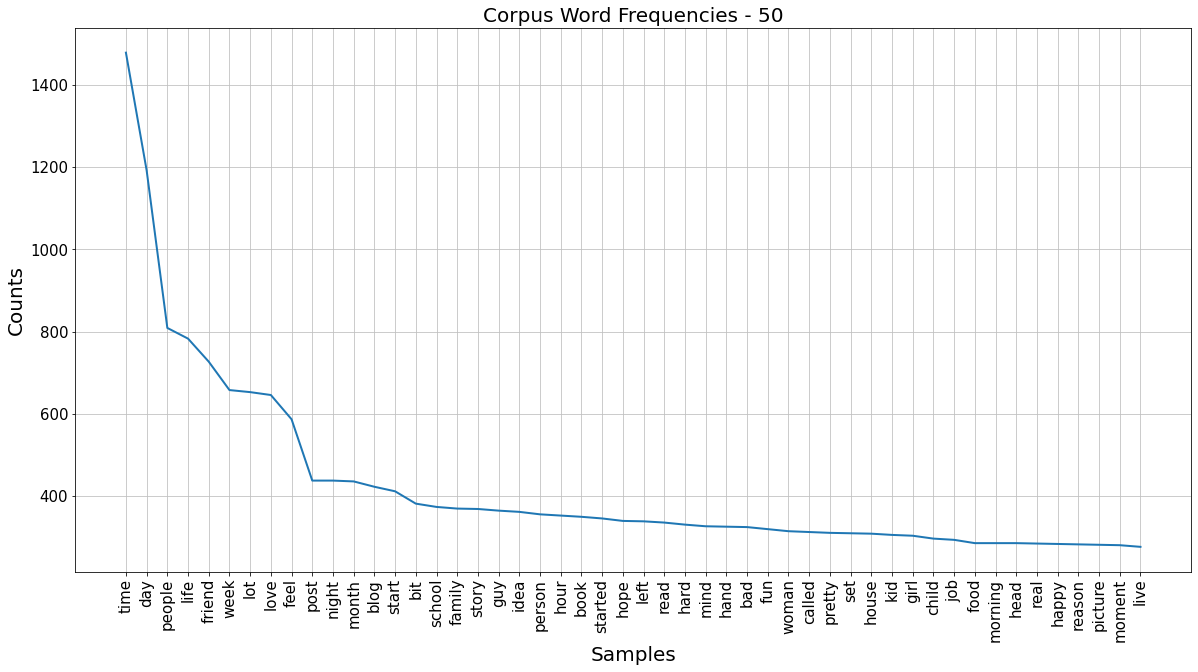

<AxesSubplot:title={'center':'Corpus Word Frequencies - 50'}, xlabel='Samples', ylabel='Counts'>

In [34]:
corpus = ','.join(df['CLEAN_TEXT'])
len(corpus)
#Set pattern for Regex tokenize: count words with apostrophes as a single word
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
# Tokenize (seperate into individual words)
regex_tokenizer = nltk.tokenize.RegexpTokenizer(pattern)
tokens = regex_tokenizer.tokenize(corpus)
#Most frequent words appearing in entire corpus
freq = nltk.FreqDist(tokens)
plt.figure(figsize=(20,10))
plt.title("Corpus Word Frequencies - 50", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Words", size = 20)
plt.ylabel("Count", size = 20)
freq.plot(50)

__Word Cloud__

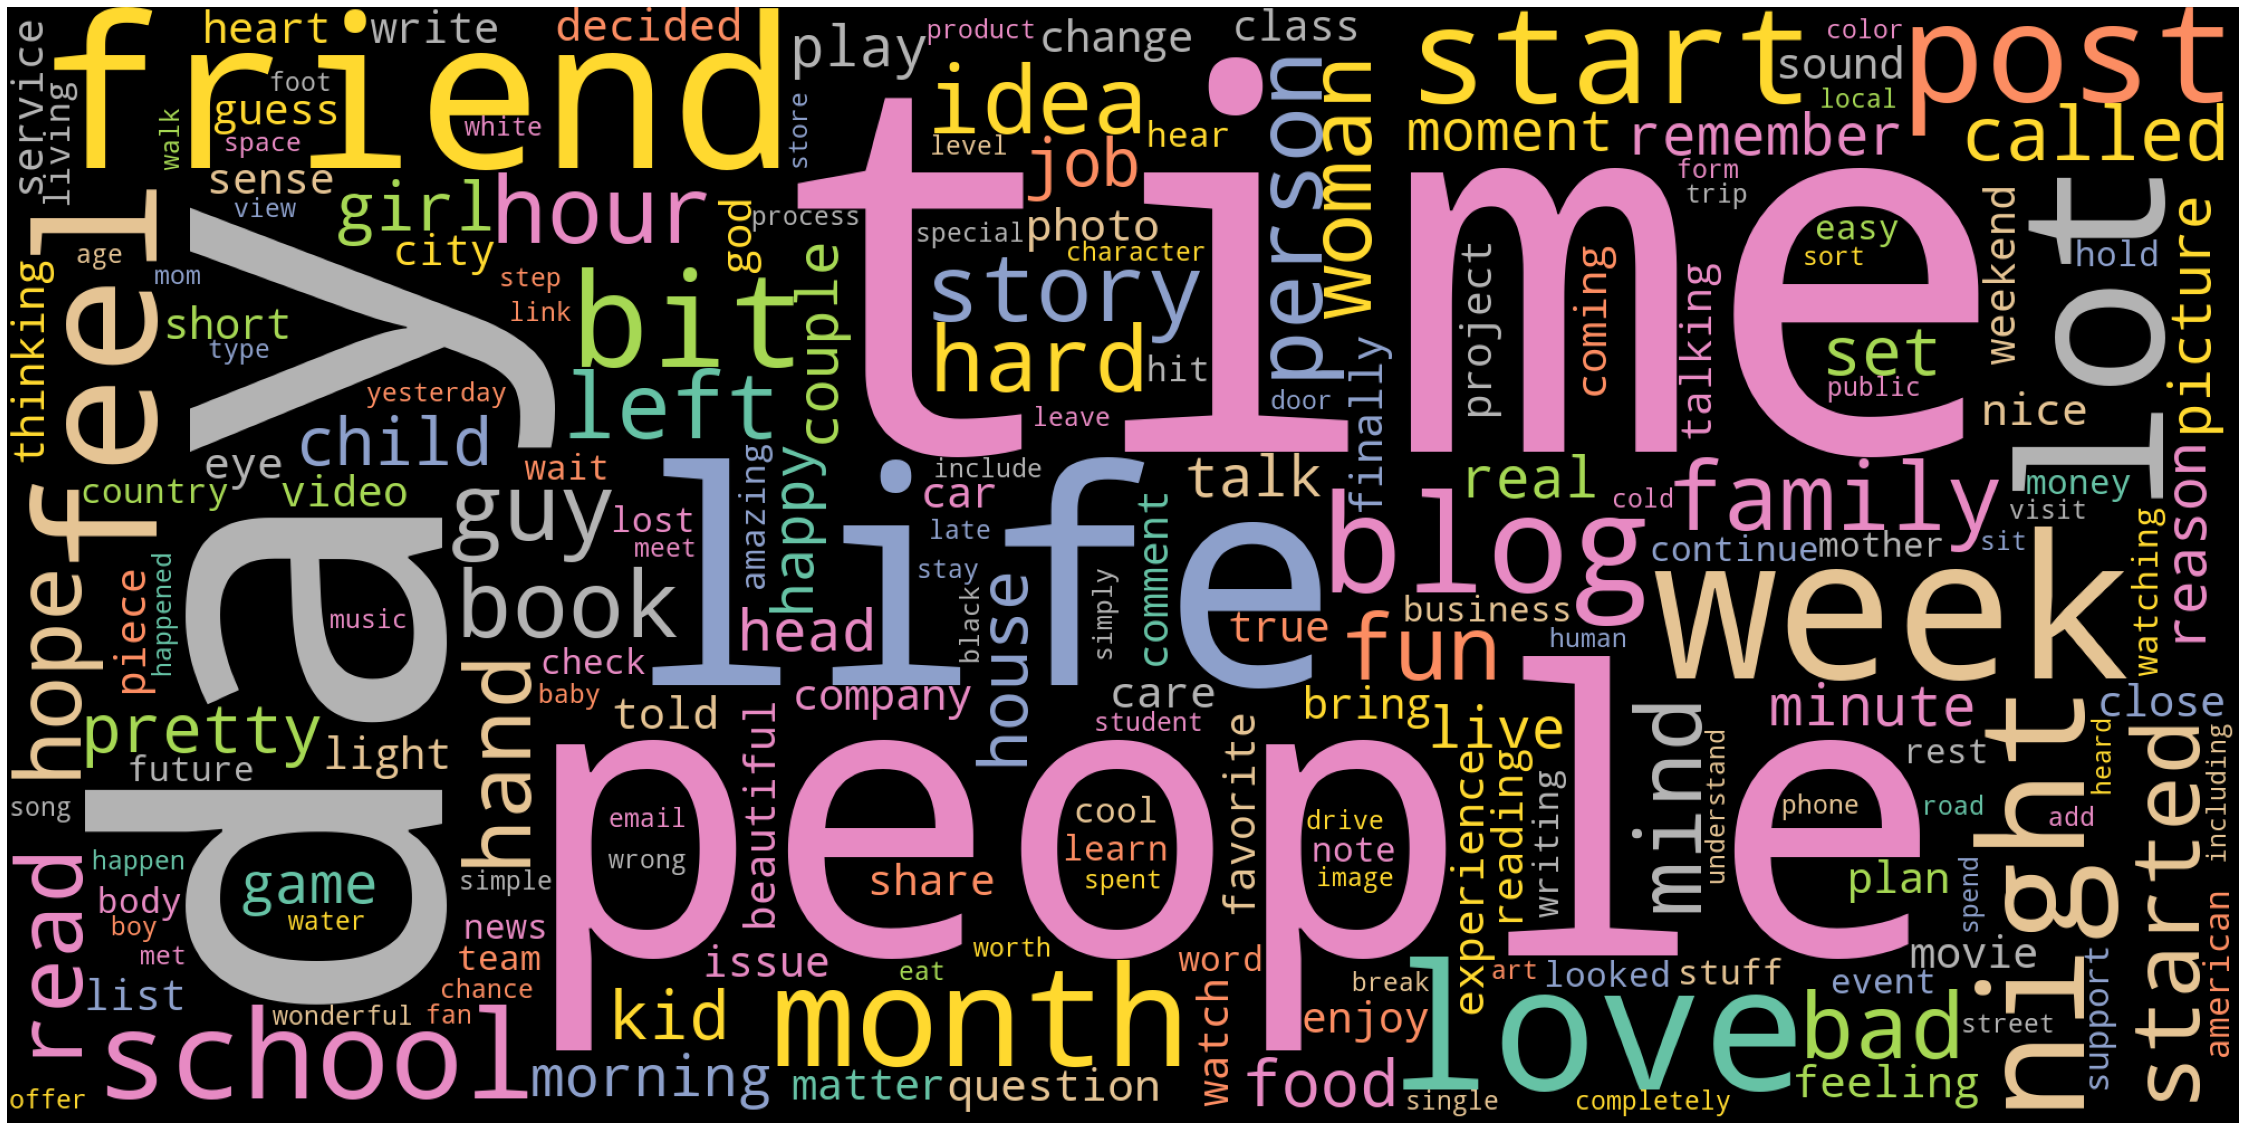

In [35]:
#Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    
text = ' '.join([text for text in df['CLEAN_TEXT']])
#Generate word cloud
wordcloud = WordCloud(width = 2000, height = 1000, background_color='black', colormap='Set2', collocations=False, stopwords = custom_stopwords).generate(text)
#Plot
plot_cloud(wordcloud)

In [36]:
# Save image
wordcloud.to_file("wordcloud.png")

__We can also create a word cloud with a mask__

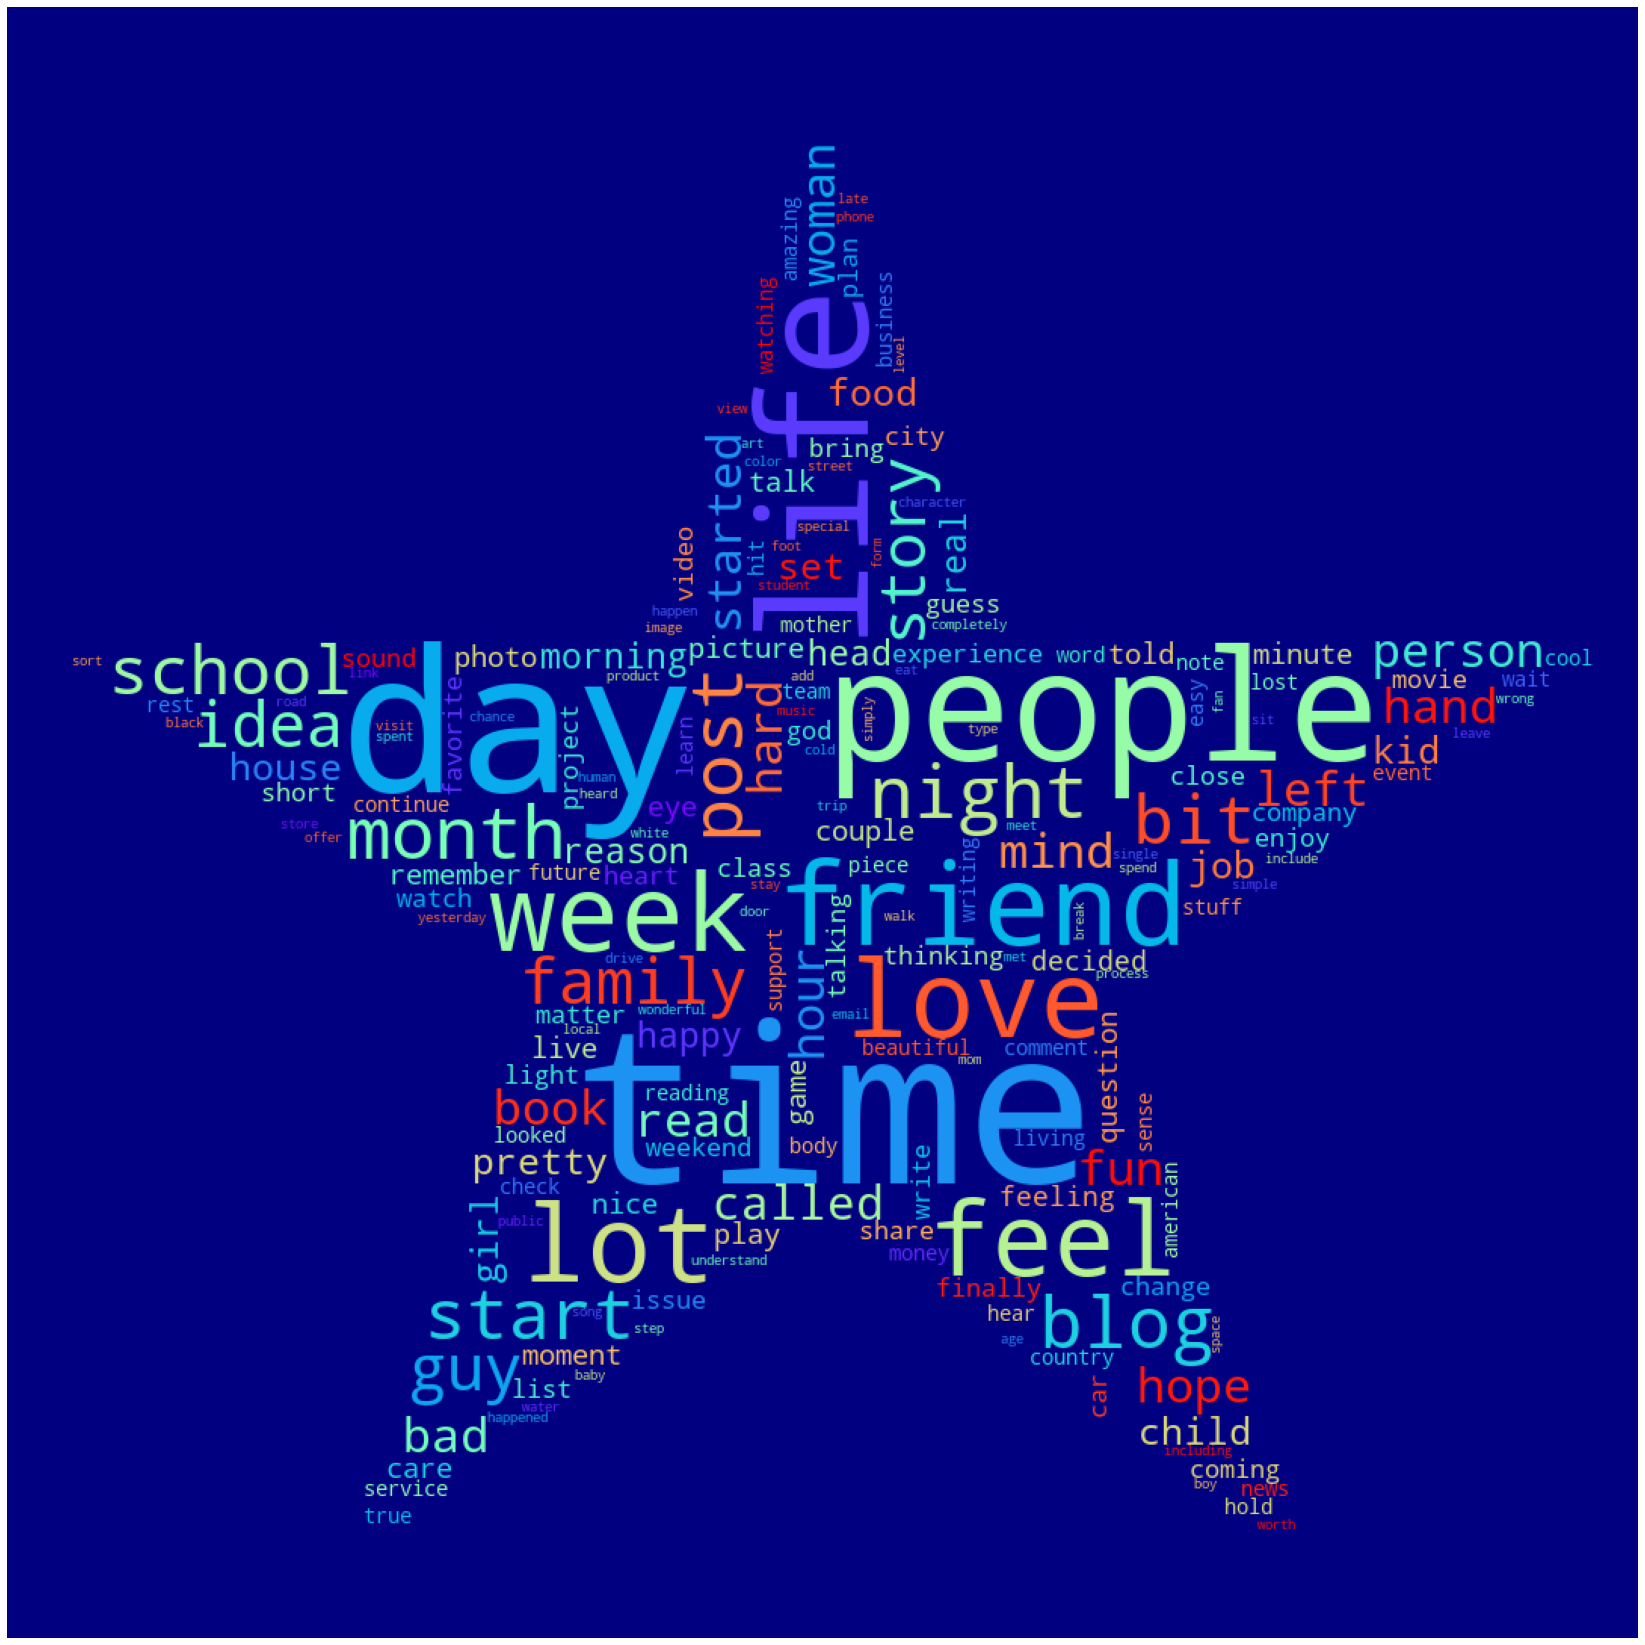

In [37]:
#Import image to np.array
mask = np.array(Image.open('star.png'))
#Generate wordcloud
wordcloud = WordCloud(width = 1000, height = 700, background_color='navy', colormap='rainbow', collocations=False, stopwords = custom_stopwords, mask=mask).generate(text)
#Plot
plot_cloud(wordcloud)

In [38]:
#Save image
wordcloud.to_file("wordcloud_star.png")

__Length Analysis__

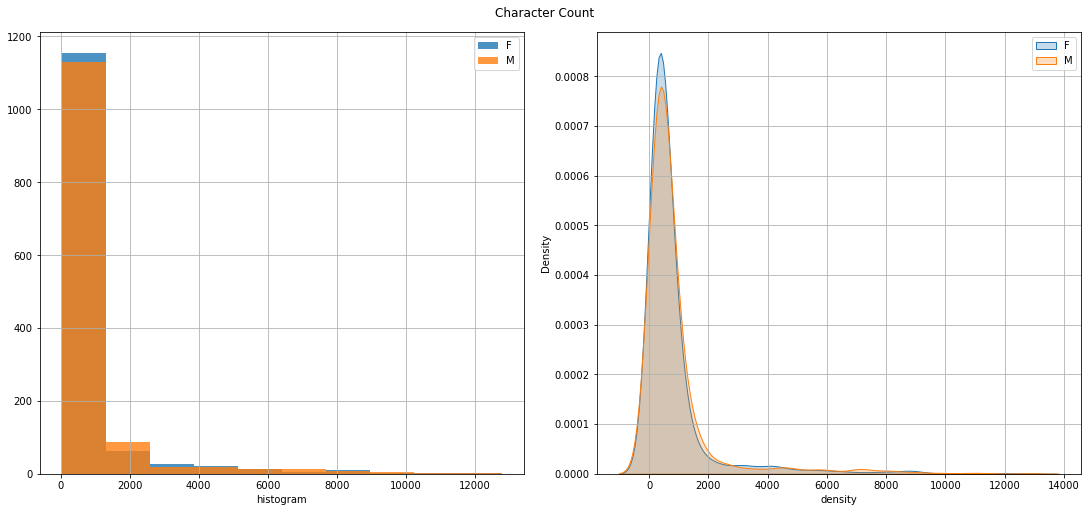

In [39]:
x, y = "char_count", "GENDER"
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,7))
for i in df_fe[y].unique():
    sns.distplot(df_fe[df_fe[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(df_fe[df_fe[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend(df_fe[y].unique())
ax[1].legend(df_fe[y].unique())
fig.suptitle("Character Count", fontsize=12)
plt.show()

__Named-Entity Recognition__

In [40]:
#call model
ner = spacy.load("en_core_web_sm")
#tag text
txt = df["CLEAN_TEXT"].iloc[7]
doc = ner(txt)
#display result
spacy.displacy.render(doc, style="ent")

__Analysis of Text based on Gender__

In [41]:
male = df_fe.loc[df['GENDER'] == 'M']
female = df_fe.loc[df['GENDER'] == 'F']
print(male.shape)
print(female.shape)

(1299, 14)
(1300, 14)


__What is the polarity distribution among male and female, who is more prone to write positive/negative threads?__

In [42]:
male['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Male - Sentiment Polarity Distribution')

female['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Female - Sentiment Polarity Distribution')

__What is the word distribution among male and female?__

In [43]:
male['word_count'].iplot(
    kind='hist',
    bins=40,
    xTitle='Word count',
    linecolor='black',
    yTitle='count',
    title='Male - Word Distribution')

female['word_count'].iplot(
    kind='hist',
    bins=40,
    xTitle='Word count',
    linecolor='black',
    yTitle='count',
    title='Female - Word Distribution')

__Distribution of top bigrams - Male__

In [44]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(male['CLEAN_TEXT'], 20)
df_bigram_male = pd.DataFrame(common_words, columns = ['CLEAN_TEXT' , 'count'])
df_bigram_male.groupby('CLEAN_TEXT').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in Blog - MALE')

__Distribution of top bigrams - Female__

In [45]:
common_words = get_top_n_bigram(female['CLEAN_TEXT'], 20)
df_bigram_female = pd.DataFrame(common_words, columns = ['CLEAN_TEXT' , 'count'])
df_bigram_female.groupby('CLEAN_TEXT').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in Blog - FEMALE')

__Distribution of top trigrams - Male__

In [46]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(male['CLEAN_TEXT'], 20)
df_trigram_male = pd.DataFrame(common_words, columns = ['CLEAN_TEXT' , 'count'])
df_trigram_male.groupby('CLEAN_TEXT').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in Blog - MALE')

__Distribution of top trigrams - Female__

In [47]:
common_words = get_top_n_trigram(female['CLEAN_TEXT'], 20)
df_trigram_female = pd.DataFrame(common_words, columns = ['CLEAN_TEXT' , 'count'])
df_trigram_female.groupby('CLEAN_TEXT').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in Blog - FEMALE')


__Part of Speech Tagging__

In [48]:
blob = TextBlob(str(male['CLEAN_TEXT']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging - Male')

blob = TextBlob(str(female['CLEAN_TEXT']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging - Female')

__Topic Modelling__

A topic model is a type of statistical model for discovering the abstract “topics” that occur in a collection of documents.
The Genism package is specialized in topic modeling.

Lets extract topics using LDA (Latent Dirichlet Allocation): a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. Basically, documents are represented as random mixtures over latent topics, where each topic is characterized by a distribution over words.

Let’s find out what topics we can extract from male blog and female blog. I need to specify the number of topics the model has to cluster, I am going to try with three.

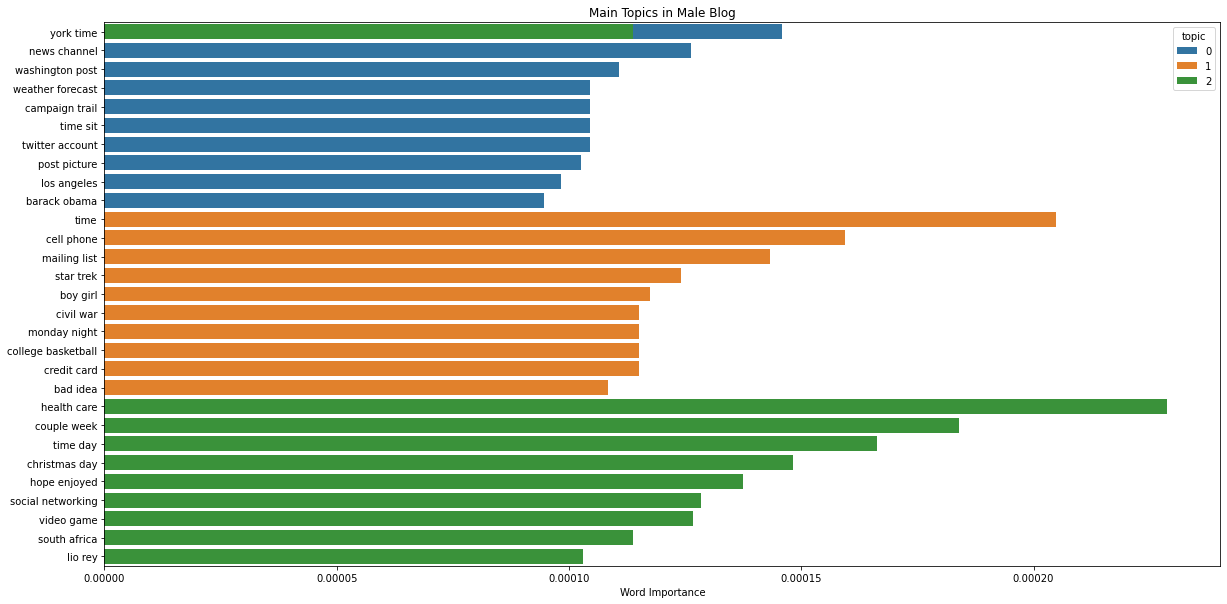

In [49]:
male_corpus = df[df["GENDER"]=="M"]["CLEAN_TEXT"]

#pre-process corpus
lst_corpus = []
for string in male_corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)
#map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)
#create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 
#train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, random_state=seed, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
#output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
df_topics_male = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])
    
#plot
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(y="word", x="weight", hue="topic", data=df_topics_male, dodge=False, ax=ax).set_title('Main Topics in Male Blog')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

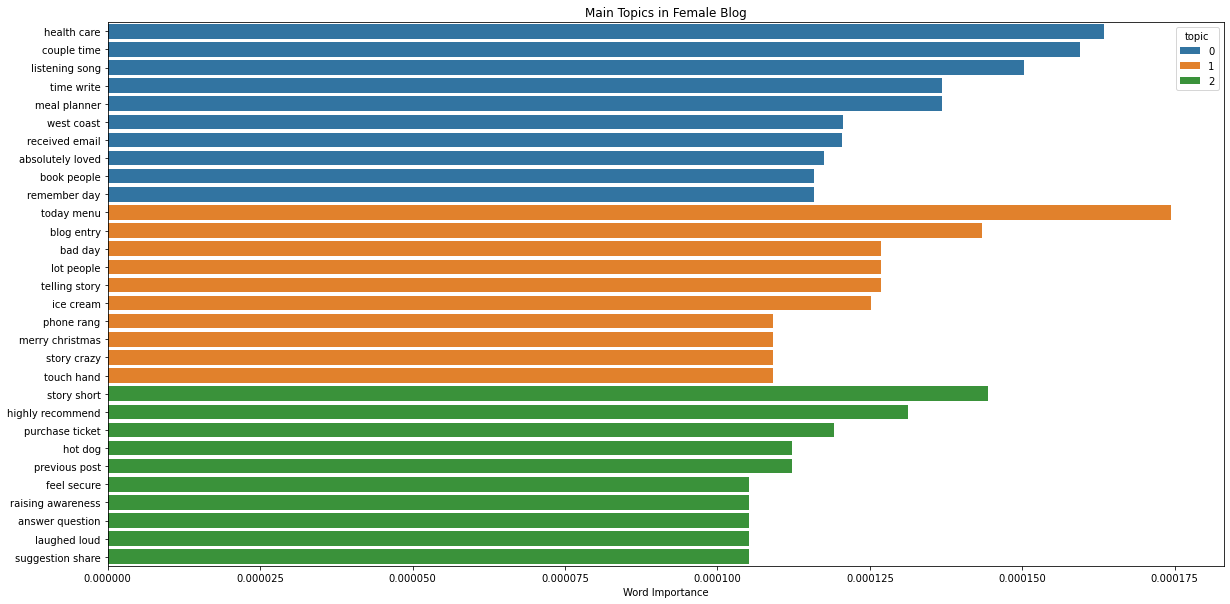

In [50]:
female_corpus = df[df["GENDER"]=="F"]["CLEAN_TEXT"]

#pre-process corpus
lst_corpus = []
for string in female_corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)
#map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)
#create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 
## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, random_state=seed, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
#output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
df_topics_female = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])
    
#plot
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(y="word", x="weight", hue="topic", data=df_topics_female, dodge=False, ax=ax).set_title('Main Topics in Female Blog')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()


__Now we will build a classification model with the three varities of the dataset which are,__

- Data with only textual columns.
- Data with text and its features.
- Data with text and POS tagging.

__Creating Word Embeddings__

After cleaning the textual data, we need to transform text into a meaningful vector (or array) of numbers. This can be done by a number of tecniques. We will use the two most common techniques which are countvectorizer and tfidvectorizer

__Bag of Words - Countvectorizer Features__

Countvectorizer converts a collection of text documents to a matrix of token counts. It is important to note here that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal.However, I did all the process manually above to just get a better understanding. Let's use a vanilla implementation of the countvectorizer without specifying any parameters.

In [51]:
#Binarize GENDER column
df["GENDER"] = df["GENDER"].map({"M":0,"F":1})

In [52]:
X = df["CLEAN_TEXT"]
y = df["GENDER"]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [54]:
df.head()

,BLOG,GENDER,TOKENS,CLEAN_TEXT
0,beyond getting there what travel days show ust...,1,"[travel, day, ustoday, guest, post, gillian, o...",travel day ustoday guest post gillian onegiant...
1,remember much about the island large lighthous...,1,"[remember, island, lighthouse, helped, fall, a...",remember island lighthouse helped fall asleep ...
2,have had asthma and allergies entire life whil...,0,"[asthma, allergy, entire, life, bet, asthmatic...",asthma allergy entire life bet asthmatic disag...
3,the last few days have been emotional rollerco...,0,"[day, emotional, rollercoaster, team, producer...",day emotional rollercoaster team producer rosh...
4,you lined all the teachers and staff school se...,1,"[lined, teacher, staff, school, search, write,...",lined teacher staff school search write blog c...


__Multinomal Naive Bayes Models__

The first model we will run will be our Naive Bayes model.  Using Bayes theorem, Naive Bayes classification models are commonly used in NLP classification problems.  The model assumes that each of the words in the text are independent.  Because the model typically performs well on test data in NLP problems, we are willing to make this assumption.  For our model, we will use the multinomial Naive Bayes model because the columns of X are integer counts.  If we had other data types, we would use either Bernoulli or Gaussian Naive Bayes models.

We will run each of our models in two ways: one using the CVEC (Count Vectorization) and another using TF-IDF. To run our models, we will set up a pipeline to run the vectorizer and the modeling one step. We will also be using GridSearchCV in order to tune the hyperparameters of both the vectorizer and the model. Finally, we will fit and score our models.

__Pipeline - CVEC + Multinomial NB__

In [55]:
mb_cvec_pipe = Pipeline([ ('cvec', CountVectorizer()),('mb', MultinomialNB())])

In [56]:
%%time
#Tune GridSearchCV
mb_cvec_pipe_params = {
    'cvec__stop_words' : [None, 'english'],  # if English, remove a list of common words from our dataset
    'cvec__decode_error' : ['ignore']  ,         # Either ignore or replace decoding errors ['ignore', 'replace'],
    'cvec__strip_accents': ['ascii']  ,          # How to deal with accents, either: ['ascii', 'unicode', None],
    'cvec__analyzer':['word']       ,            # How CVEC will create columns, either by word or character ['word', 'char', 'char_wb'] ,
    'cvec__max_features': [1250, 1300, 1350, 1400], # How many features to create in the matrix.
    'cvec__max_df' : [.1, .15, .2, .25], #ignore terms that occur in more than the indicated portion of documents
    'cvec__min_df' : [0, .05, .01], # ignore terms that occur in fewer than the indicated portion of documents
    'cvec__ngram_range' : [(1,1), (1, 2)] # create terms using either one or two word combinations
}
mb_cvec_gs = GridSearchCV(mb_cvec_pipe, scoring = "accuracy", param_grid=mb_cvec_pipe_params, cv=3, n_jobs=-1)
mb_cvec_gs.fit(X_train,y_train)

Wall time: 49.9 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__analyzer': ['word'],
                         'cvec__decode_error': ['ignore'],
                         'cvec__max_df': [0.1, 0.15, 0.2, 0.25],
                         'cvec__max_features': [1250, 1300, 1350, 1400],
                         'cvec__min_df': [0, 0.05, 0.01],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'cvec__strip_accents': ['ascii']},
             scoring='accuracy')

In [57]:
mb_cvec_gs.best_score_

0.6849446849446849

In [58]:
mb_cvec_gs.best_params_

{'cvec__analyzer': 'word',
 'cvec__decode_error': 'ignore',
 'cvec__max_df': 0.25,
 'cvec__max_features': 1300,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'cvec__strip_accents': 'ascii'}

In [59]:
#Train score
mb_cvec_gs.score(X_train, y_train)

0.7267917267917268

In [60]:
#Test score
mb_cvec_gs.score(X_test, y_test)

0.6865384615384615

__Pipeline - TF IDF + Multinomial NB__

In [61]:
mb_tvec_pipe = Pipeline([ ('tvec', TfidfVectorizer()),('mb', MultinomialNB())])

In [62]:
%%time
#Tune GridSearchCV
mb_tvec_pipe_params = {
    'tvec__stop_words' : [None, 'english'],
    'tvec__decode_error' : ['ignore']  ,         
    'tvec__strip_accents': ['ascii']  ,          
    'tvec__analyzer':['word']       ,           
    'tvec__max_features': [    2000, 2250, 2500], 
    'tvec__max_df' : [.1, .15, .2, .25],
    'tvec__min_df' : [0, .05, .01],
    'tvec__ngram_range' : [(1,1), (1, 2)] 
}
mb_tvec_gs = GridSearchCV(mb_tvec_pipe, scoring = "accuracy", param_grid=mb_tvec_pipe_params, cv=3, n_jobs=-1)
mb_tvec_gs.fit(X_train,y_train)

Wall time: 37.2 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__analyzer': ['word'],
                         'tvec__decode_error': ['ignore'],
                         'tvec__max_df': [0.1, 0.15, 0.2, 0.25],
                         'tvec__max_features': [2000, 2250, 2500],
                         'tvec__min_df': [0, 0.05, 0.01],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english'],
                         'tvec__strip_accents': ['ascii']},
             scoring='accuracy')

In [63]:
mb_tvec_gs.best_score_

0.682058682058682

In [64]:
mb_tvec_gs.best_params_

{'tvec__analyzer': 'word',
 'tvec__decode_error': 'ignore',
 'tvec__max_df': 0.15,
 'tvec__max_features': 2250,
 'tvec__min_df': 0,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None,
 'tvec__strip_accents': 'ascii'}

In [65]:
#Train score
mb_tvec_gs.score(X_train, y_train)

0.7902837902837903

In [66]:
#Test score
mb_tvec_gs.score(X_test, y_test)

0.6884615384615385

__Logistic Regression (LR) Models__

Logistic Regressions assumes that X1 - Xn are linearly realted to the log odds that y=1, that all of the errors are independent of one another, that the distribution of errors follows the Bernoulli distribution, and that all of the independent variables are independent of one another. 

Like with Multinomial Naive Bayes, we will test the model out using both CVEC and TF-IDF.

__Pipeline - CVEC + LR__

In [67]:
lr_cvec_pipe = Pipeline([('cvec', CountVectorizer()),('lr', LogisticRegression())])

In [68]:
%%time
#Tune GridSearchCV
lr_cvec_pipe_params = {
    'cvec__stop_words' : [None, 'english'],
    'cvec__decode_error' : ['ignore']  ,         
    'cvec__strip_accents': ['ascii']  ,         
    'cvec__analyzer':['word']       ,            
    'cvec__max_features': [    1500, 1750, 2000], 
    'cvec__max_df' : [.1, .15, .2, .25],
    'cvec__min_df' : [0, .05, .01],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'lr__penalty' : ['l1', 'l2']
}
lr_cvec_gs = GridSearchCV(lr_cvec_pipe, scoring = "accuracy", param_grid=lr_cvec_pipe_params, cv=3, n_jobs = 1)
lr_cvec_gs.fit(X_train,y_train)

Wall time: 5min 42s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=1,
             param_grid={'cvec__analyzer': ['word'],
                         'cvec__decode_error': ['ignore'],
                         'cvec__max_df': [0.1, 0.15, 0.2, 0.25],
                         'cvec__max_features': [1500, 1750, 2000],
                         'cvec__min_df': [0, 0.05, 0.01],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'cvec__strip_accents': ['ascii'],
                         'lr__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [69]:
lr_cvec_gs.best_score_

0.6507936507936508

In [70]:
lr_cvec_gs.best_params_

{'cvec__analyzer': 'word',
 'cvec__decode_error': 'ignore',
 'cvec__max_df': 0.15,
 'cvec__max_features': 1750,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'cvec__strip_accents': 'ascii',
 'lr__penalty': 'l2'}

In [71]:
#Train score
lr_cvec_gs.score(X_train, y_train)

0.9725829725829725

In [72]:
#Test score
lr_cvec_gs.score(X_test, y_test)

0.6403846153846153

__Pipeline - TF IDF + LR__

In [73]:
lr_tfidf_pipe = Pipeline([('tvec',TfidfVectorizer()),('lr', LogisticRegression())])

In [74]:
%%time
#Tune GridSearchCV
lr_tfidf_pipe_params = {
    'tvec__stop_words' : [None, 'english'],
    'tvec__decode_error' : ['ignore']  ,         
    'tvec__strip_accents': ['ascii']  ,          
    'tvec__analyzer':['word']       ,            
    'tvec__max_features': [    2000, 2250, 2500], 
    'tvec__max_df' : [.1, .15, .2, .25],
    'tvec__min_df' : [0, .05, .01],
    'tvec__ngram_range' : [(1,1), (1, 2)],
    'lr__penalty' : ['l1', 'l2']

}
lr_tfidf_gs = GridSearchCV(lr_tfidf_pipe, scoring = "accuracy", param_grid=lr_tfidf_pipe_params, cv=3, n_jobs=-1)
lr_tfidf_gs.fit(X_train,y_train);

Wall time: 1min 11s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__penalty': ['l1', 'l2'],
                         'tvec__analyzer': ['word'],
                         'tvec__decode_error': ['ignore'],
                         'tvec__max_df': [0.1, 0.15, 0.2, 0.25],
                         'tvec__max_features': [2000, 2250, 2500],
                         'tvec__min_df': [0, 0.05, 0.01],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english'],
                         'tvec__strip_accents': ['ascii']},
             scoring='accuracy')

In [75]:
lr_tfidf_gs.best_score_

0.6902356902356903

In [76]:
lr_tfidf_gs.best_params_

{'lr__penalty': 'l2',
 'tvec__analyzer': 'word',
 'tvec__decode_error': 'ignore',
 'tvec__max_df': 0.25,
 'tvec__max_features': 2250,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None,
 'tvec__strip_accents': 'ascii'}

In [77]:
#Train score
lr_tfidf_gs.score(X_train, y_train)

0.8672438672438673

In [78]:
#Test score
lr_tfidf_gs.score(X_test, y_test)

0.6846153846153846

__Random Forest (RF) Models__

Next, we will test out the random forest model.  Random forest takes a classic decision tree, and adds in bootstrapping (sampling of X rows with replacement) and randomized feature selection.  Based on the 'n_features' hyperparameter we will set in the GridSearch, we will create multiple trees.  Using the 'max_depth' hyperparameter, we will set the number of features that will be considered in our trees.  Random forest models generally have lower variance than either classic decision trees or bagged decision trees.  Since we saw high variance in our Naive Bayes and logistic regression models, a random forest model may be a good option for our data.

__Pipeline - CVEC  + RF__

In [79]:
rf_cvec_pipe = Pipeline([('cvec', CountVectorizer()),('rf', RandomForestClassifier())])

In [80]:
%%time
#Tune GridSearchCV
rf_cvec_pipe_params = {
    'cvec__stop_words' : [None, 'english'],
    'cvec__decode_error' : ['ignore']  ,         
    'cvec__strip_accents': ['ascii']  ,         
    'cvec__analyzer':['word']       ,           
    'cvec__max_features': [   1250, 1400, 1500], 
    'cvec__max_df' : [.2,  .25, .3], 
    'cvec__min_df' : [0, .05, .01],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'rf__n_estimators': [30, 40, 50], 
    'rf__max_depth': [  200, 225, 250] 
}
rf_cvec_gs = GridSearchCV(rf_cvec_pipe, scoring = "accuracy", param_grid=rf_cvec_pipe_params, cv=3, n_jobs=-1)
rf_cvec_gs.fit(X_train,y_train);

Wall time: 5min 35s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__analyzer': ['word'],
                         'cvec__decode_error': ['ignore'],
                         'cvec__max_df': [0.2, 0.25, 0.3],
                         'cvec__max_features': [1250, 1400, 1500],
                         'cvec__min_df': [0, 0.05, 0.01],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'cvec__strip_accents': ['ascii'],
                         'rf__max_depth': [200, 225, 250],
                         'rf__n_estimators': [30, 40, 50]},
             scoring='accuracy')

In [81]:
rf_cvec_gs.best_score_

0.683982683982684

In [82]:
rf_cvec_gs.best_params_

{'cvec__analyzer': 'word',
 'cvec__decode_error': 'ignore',
 'cvec__max_df': 0.3,
 'cvec__max_features': 1400,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'cvec__strip_accents': 'ascii',
 'rf__max_depth': 250,
 'rf__n_estimators': 50}

In [83]:
#Train score
rf_cvec_gs.score(X_train, y_train)

1.0

In [84]:
#Test score
rf_cvec_gs.score(X_test, y_test)

0.6634615384615384

__Pipeline - TFIDF  + RF__

In [85]:
rf_tfidf_pipe = Pipeline([('tvec', TfidfVectorizer()),('rf', RandomForestClassifier())])

In [86]:
%%time
# Tune GridSearchCV
rf_tfidf_pipe_params = {
    'tvec__stop_words' : [None, 'english'],
    'tvec__decode_error' : ['ignore']  ,         
    'tvec__strip_accents': ['ascii']  ,          
    'tvec__analyzer':['word']       ,            
    'tvec__max_features': [  1250, 1350, 1500], 
    'tvec__max_df' : [.15, .20, .25, .3], 
    'tvec__min_df' : [0], 
    'tvec__ngram_range' : [(1,1)], 
    'rf__n_estimators': [ 75, 100, 125], 
    'rf__max_depth': [ 200, 225, 250] 
}
rf_tfidf_gs = GridSearchCV(rf_tfidf_pipe, scoring = "accuracy", param_grid=rf_tfidf_pipe_params, cv=3)
rf_tfidf_gs.fit(X_train,y_train);

Wall time: 7min 38s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [200, 225, 250],
                         'rf__n_estimators': [75, 100, 125],
                         'tvec__analyzer': ['word'],
                         'tvec__decode_error': ['ignore'],
                         'tvec__max_df': [0.15, 0.2, 0.25, 0.3],
                         'tvec__max_features': [1250, 1350, 1500],
                         'tvec__min_df': [0], 'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': [None, 'english'],
                         'tvec__strip_accents': ['ascii']},
             scoring='accuracy')

In [87]:
rf_tfidf_gs.best_params_

{'rf__max_depth': 200,
 'rf__n_estimators': 125,
 'tvec__analyzer': 'word',
 'tvec__decode_error': 'ignore',
 'tvec__max_df': 0.2,
 'tvec__max_features': 1250,
 'tvec__min_df': 0,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None,
 'tvec__strip_accents': 'ascii'}

In [88]:
rf_tfidf_gs.best_score_

0.6806156806156807

In [89]:
#Train score
rf_tfidf_gs.score(X_train, y_train)

1.0

In [90]:
#Test score
rf_tfidf_gs.score(X_test, y_test)

0.6557692307692308

__Tuning AdaBoost Classifier__

The AdaBoost classifier will first fit our data to the DecisionTree classifier, and then fit more copies of the tree, giving higher weights to the classes that were incorrectly classified in earlier runs.  This should give us a model that performs more accurately on the test data (unseen).

In addition to setting the hyperparameters that we set in earlier models, we will also enter values for the number of estimators we want to use, how many levels our tree can contain, and the n_learning_rate (how much each classifier contributes).

__CVEC + Tuning AdaBoostClassifier__

In [91]:
ada_cvec_pipe = Pipeline([('cvec', CountVectorizer()),('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))])

In [92]:
%%time
#Tune GridSearchCV
ada_cvec_pipe_params = {
    'cvec__stop_words' : [None, 'english'],
    'cvec__decode_error' : ['ignore']  ,         
    'cvec__strip_accents': ['ascii']  ,          
    'cvec__analyzer':['word']       ,           
    'cvec__max_features': [ 1000,  1250, 1350], 
    'cvec__max_df' : [.15, .20, .25,], 
    'cvec__min_df' : [0, .025], 
    'cvec__ngram_range' : [(1,1), (1,2)], 
    'ada__n_estimators': [50, 60, 75], 
    'ada__base_estimator__max_depth': [   275, 300, 325], 
    'ada__learning_rate' : [.6, .7, .8] 
}
ada_cvec_gs = GridSearchCV(ada_cvec_pipe, scoring = "accuracy", param_grid=ada_cvec_pipe_params, cv=3, n_jobs=-1)
ada_cvec_gs.fit(X_train,y_train);

Wall time: 9min 38s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
             n_jobs=-1,
             param_grid={'ada__base_estimator__max_depth': [275, 300, 325],
                         'ada__learning_rate': [0.6, 0.7, 0.8],
                         'ada__n_estimators': [50, 60, 75],
                         'cvec__analyzer': ['word'],
                         'cvec__decode_error': ['ignore'],
                         'cvec__max_df': [0.15, 0.2, 0.25],
                         'cvec__max_features': [1000, 1250, 1350],
                         'cvec__min_df': [0, 0.025],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'cvec__strip_accents': ['ascii']},
             scoring='accuracy')

In [93]:
ada_cvec_gs.best_params_

{'ada__base_estimator__max_depth': 275,
 'ada__learning_rate': 0.6,
 'ada__n_estimators': 75,
 'cvec__analyzer': 'word',
 'cvec__decode_error': 'ignore',
 'cvec__max_df': 0.2,
 'cvec__max_features': 1350,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'cvec__strip_accents': 'ascii'}

In [94]:
ada_cvec_gs.best_score_

0.6046176046176046

In [95]:
#Train score
ada_cvec_gs.score(X_train, y_train)

1.0

In [96]:
#Test score
ada_cvec_gs.score(X_test, y_test)

0.6019230769230769

__TVEC + Tuning AdaBoostClassifier__

In [97]:
ada_tvec_pipe = Pipeline([('tvec', TfidfVectorizer()), ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))])

In [98]:
%%time
#Tune GridSearchCV
ada_tvec_pipe_params = {
    'tvec__stop_words' : [None, 'english'],
    'tvec__decode_error' : ['ignore']  ,         
    'tvec__strip_accents': ['ascii']  ,          
    'tvec__analyzer':['word']       ,           
    'tvec__max_features': [  1250], 
    'tvec__max_df' : [  .20, .25, .275], 
    'tvec__min_df' : [0, .025], 
    'tvec__ngram_range' : [(1,1)], 
    'ada__n_estimators': [  120, 130, 150], 
    'ada__base_estimator__max_depth': [  290, 310, 320], 
    'ada__learning_rate' : [.75, .8,  .9] 
}
ada_tvec_gs = GridSearchCV(ada_tvec_pipe, scoring = "accuracy", param_grid=ada_tvec_pipe_params, cv=3, n_jobs=-1)
ada_tvec_gs.fit(X_train,y_train);

Wall time: 1min 8s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
             n_jobs=-1,
             param_grid={'ada__base_estimator__max_depth': [290, 310, 320],
                         'ada__learning_rate': [0.75, 0.8, 0.9],
                         'ada__n_estimators': [120, 130, 150],
                         'tvec__analyzer': ['word'],
                         'tvec__decode_error': ['ignore'],
                         'tvec__max_df': [0.2, 0.25, 0.275],
                         'tvec__max_features': [1250],
                         'tvec__min_df': [0, 0.025],
                         'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': [None, 'english'],
                         'tvec__strip_accents': ['ascii']},
             scoring='accuracy')

In [99]:
ada_tvec_gs.best_params_

{'ada__base_estimator__max_depth': 290,
 'ada__learning_rate': 0.9,
 'ada__n_estimators': 150,
 'tvec__analyzer': 'word',
 'tvec__decode_error': 'ignore',
 'tvec__max_df': 0.2,
 'tvec__max_features': 1250,
 'tvec__min_df': 0.025,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english',
 'tvec__strip_accents': 'ascii'}

In [100]:
ada_tvec_gs.best_score_

0.6075036075036075

In [101]:
#Train score
ada_tvec_gs.score(X_train, y_train)

0.9995189995189995

In [102]:
#Test score
ada_tvec_gs.score(X_test, y_test)

0.5576923076923077

__Voting Classifier__

Using voting classifier to vote between MultiNomial NB, Linear Regression, and RF (the three models that gave us the highest test accuracy).  This will run the three models that we enter, compare the classifications, and vote on the winner.  If two models indicate that a blog is written by male and one indicates that it is written by female, than the result will be that we classify the blog as written by male.

Because TF-IDF performed the best (highest test accuracy) for the three models that we are using in the voting classifier, we will only use TF-IDF here.

In [103]:
#run data through tf-idf
tvec = TfidfVectorizer(decode_error='ignore', max_df=0.25,max_features=1250, min_df=0, ngram_range=(1,2), stop_words=custom_stopwords )
X_train_vote = tvec.fit_transform(X_train)

In [104]:
#tvec = TfidfVectorizer()
X_test_vote = tvec.transform(X_test)

In [105]:
vote = VotingClassifier([
    ('mb', MultinomialNB()),
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier())
])

In [106]:
vote_params = {
    'lr__penalty' : ['l1', 'l2'],
    'rf__n_estimators': [  100, 125, 150], 
    'rf__max_depth': [ 200, 225, 250]
}
gs = GridSearchCV(vote, param_grid=vote_params, scoring = "accuracy", cv=3, n_jobs=-1)

In [107]:
gs.fit(X_train_vote, y_train)

GridSearchCV(cv=3,
             estimator=VotingClassifier(estimators=[('mb', MultinomialNB()),
                                                    ('lr',
                                                     LogisticRegression()),
                                                    ('rf',
                                                     RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'lr__penalty': ['l1', 'l2'],
                         'rf__max_depth': [200, 225, 250],
                         'rf__n_estimators': [100, 125, 150]},
             scoring='accuracy')

In [108]:
gs.best_params_

{'lr__penalty': 'l2', 'rf__max_depth': 200, 'rf__n_estimators': 100}

In [109]:
#Train score
gs.score(X_train_vote, y_train)

0.8595478595478595

In [110]:
#Test score
gs.score(X_test_vote, y_test)

0.6807692307692308

__Evaluation Metrics__

Now that we have run all of our models, we can formally compare them.  We will create a function that will take in the models that we ran above and create the predictions for the model.  Next, it will calculate all of the metrics needed for the confusion matrix (true negatives, false positives, false negatives, and false positives).  Finally, it will calculate the accuracy and append this to a DataFrame.

In [111]:
metrics = []

In [112]:
def eval_metrics(model_name,  name_for_df):
    pred = model_name.predict(X_test)
    conf = confusion_matrix( y_test,# True values.
                      pred)# Predicted values.
                      
    tn, fp, fn, tp = conf.ravel()
    

    spec = tn / (tn + fp)
    print(f'Specificity: {round(spec,4)}')

    sens = tp / (tp + fn)
    print(f'Sensitivity: {round(sens,4)}')

    acc = (tp + tn) / (tp + fp + fn + tn)
    
    print(f'Accuracy: {round(acc,4)}')
    metrics.append([name_for_df,  acc])
    print(metrics)
    df= pd.DataFrame(conf, index =  ['actual male', 'actual female'], columns = ['predicted male', 'predicted female'])
    return df


__Multinomial Naive Bayes with CVEC__

In [113]:
eval_metrics(mb_cvec_gs,  'MB CVEC')

Specificity: 0.6245
Sensitivity: 0.753
Accuracy: 0.6865
[['MB CVEC', 0.6865384615384615]]


,predicted male,predicted female
actual male,168,101
actual female,62,189


__Multinomial Naive bayes with TF-IDF__

In [114]:
eval_metrics(mb_tvec_gs,  'MB TVEC')

Specificity: 0.6097
Sensitivity: 0.7729
Accuracy: 0.6885
[['MB CVEC', 0.6865384615384615], ['MB TVEC', 0.6884615384615385]]


,predicted male,predicted female
actual male,164,105
actual female,57,194


__Logistic regression with CVEC__

In [115]:
eval_metrics(lr_cvec_gs, 'LR CVEC')

Specificity: 0.6283
Sensitivity: 0.6534
Accuracy: 0.6404
[['MB CVEC', 0.6865384615384615], ['MB TVEC', 0.6884615384615385], ['LR CVEC', 0.6403846153846153]]


,predicted male,predicted female
actual male,169,100
actual female,87,164


__Logistic regression with TF-IDF__

In [116]:
eval_metrics(lr_tfidf_gs, 'LR TVEC')

Specificity: 0.6803
Sensitivity: 0.6892
Accuracy: 0.6846
[['MB CVEC', 0.6865384615384615], ['MB TVEC', 0.6884615384615385], ['LR CVEC', 0.6403846153846153], ['LR TVEC', 0.6846153846153846]]


,predicted male,predicted female
actual male,183,86
actual female,78,173


__Random Forest with CVEC__

In [117]:
eval_metrics(rf_cvec_gs, 'RF CVEC')

Specificity: 0.6654
Sensitivity: 0.6614
Accuracy: 0.6635
[['MB CVEC', 0.6865384615384615], ['MB TVEC', 0.6884615384615385], ['LR CVEC', 0.6403846153846153], ['LR TVEC', 0.6846153846153846], ['RF CVEC', 0.6634615384615384]]


,predicted male,predicted female
actual male,179,90
actual female,85,166


__Random Forest with TF-IDF__

In [118]:
eval_metrics(rf_tfidf_gs, 'RF TVEC')

Specificity: 0.6171
Sensitivity: 0.6972
Accuracy: 0.6558
[['MB CVEC', 0.6865384615384615], ['MB TVEC', 0.6884615384615385], ['LR CVEC', 0.6403846153846153], ['LR TVEC', 0.6846153846153846], ['RF CVEC', 0.6634615384615384], ['RF TVEC', 0.6557692307692308]]


,predicted male,predicted female
actual male,166,103
actual female,76,175


__AdaBoost with CVEC__

In [119]:
eval_metrics(ada_cvec_gs, 'ADA CVEC')

Specificity: 0.5725
Sensitivity: 0.6335
Accuracy: 0.6019
[['MB CVEC', 0.6865384615384615], ['MB TVEC', 0.6884615384615385], ['LR CVEC', 0.6403846153846153], ['LR TVEC', 0.6846153846153846], ['RF CVEC', 0.6634615384615384], ['RF TVEC', 0.6557692307692308], ['ADA CVEC', 0.6019230769230769]]


,predicted male,predicted female
actual male,154,115
actual female,92,159


__AdaBoost with TF-IDF__

In [120]:
eval_metrics(ada_tvec_gs, 'ADA TVEC')

Specificity: 0.5242
Sensitivity: 0.5936
Accuracy: 0.5577
[['MB CVEC', 0.6865384615384615], ['MB TVEC', 0.6884615384615385], ['LR CVEC', 0.6403846153846153], ['LR TVEC', 0.6846153846153846], ['RF CVEC', 0.6634615384615384], ['RF TVEC', 0.6557692307692308], ['ADA CVEC', 0.6019230769230769], ['ADA TVEC', 0.5576923076923077]]


,predicted male,predicted female
actual male,141,128
actual female,102,149


__Voting Classifier with TF-IDF__

In [121]:
pred = gs.predict(X_test_vote)
conf = confusion_matrix( y_test,# True values.
                  pred)# Predicted values.
tn, fp, fn, tp = conf.ravel()

spec = tn / (tn + fp)
print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)
print(f'Sensitivity: {round(sens,4)}')

acc = (tp + tn) / (tp + fp + fn + tn)
print(f'Accuracy: {round(acc,4)}')
metrics.append(['Voting',  acc])
voting_df= pd.DataFrame(conf, index =  ['actual male', 'actual female'], columns = ['predicted male', 'predicted female'])
voting_df

Specificity: 0.6357
Sensitivity: 0.7291
Accuracy: 0.6808


,predicted male,predicted female
actual male,171,98
actual female,68,183


In [122]:
metrics_df = pd.DataFrame(metrics, columns=['model', 'acc'])

In [123]:
metrics_df = metrics_df.sort_values(by='acc', ascending = False)
metrics_df

,model,acc
1,MB TVEC,0.688462
0,MB CVEC,0.686538
3,LR TVEC,0.684615
8,Voting,0.680769
4,RF CVEC,0.663462
5,RF TVEC,0.655769
2,LR CVEC,0.640385
6,ADA CVEC,0.601923
7,ADA TVEC,0.557692


__Deep Learning__

In [124]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50

In [125]:
train_data, test_data = train_test_split(df, test_size=0.15,random_state=seed) # Splits Dataset into Training and Testing set
                                         
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 2209
Test Data size 390


In [126]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.CLEAN_TEXT)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 48554


- __tokenizer__ create tokens for every word in the data corpus and map them to a index using dictionary.
- __word_index__ contains the index for each word
- __vocab_size__ represents the total number of word in the data corpus

Now we got a tokenizer object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in blogs have different count of words in it. To avoid this, we seek a little help from pad_sequence to do our job. It will make all the sequence in one constant length MAX_SEQUENCE_LENGTH

In [127]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.CLEAN_TEXT),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.CLEAN_TEXT),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (2209, 50)
Testing X Shape: (390, 50)


In [128]:
encoder = LabelEncoder()
encoder.fit(train_data.GENDER.to_list())

y_train = encoder.transform(train_data.GENDER.to_list())
y_test = encoder.transform(test_data.GENDER.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (2209, 1)
y_test shape: (390, 1)


__Word Emdedding__

In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it.Word Embedding is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.
We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use Transfer Learning. We download the pre-trained embedding and use it in our model.
The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification.

__Note : You can download the GloVe vectors from here http://www-nlp.stanford.edu/data/glove.840B.300d.zip__

In [129]:
GLOVE_EMB = 'D:/Msc in AI/NLP/glove.6B/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024

In [130]:
embeddings_index = {}

f = open(GLOVE_EMB, encoding="utf8")
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [131]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [132]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


__Model Training - LSTM__

We are clear to build our Deep Learning model. While developing a DL model, we should keep in mind of key things like Model Architecture, Hyperparmeter Tuning and Performance of the model.

As we have seen in the word cloud, there are some words predominantly feature in both male and female blogs. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc.. That's why we use Sequence Models.

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction.

For model architecture, we use

1) __Embedding Layer__ - Generates Embedding Vector for each input sequence.

2) __Conv1D Layer__ - Its using to convolve data into smaller feature vectors.

3) __LSTM__ - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) __Dense__ - Fully Connected Layers for classification

In [133]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


__Optimization Algorithm__

We use Adam, optimization algorithm for Gradient Descent.

__Callbacks__

Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

- __LRScheduler__ - It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.

- __ModelCheckPoint__ - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [134]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [135]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=20,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Train on 2209 samples, validate on 390 samples
Epoch 1/20
2209/2209 [==============================] - 2s 880us/sample - loss: 0.6923 - acc: 0.5333 - val_loss: 0.6850 - val_acc: 0.5590
Epoch 2/20
2209/2209 [==============================] - 1s 520us/sample - loss: 0.6847 - acc: 0.5555 - val_loss: 0.6703 - val_acc: 0.5795
Epoch 3/20
2209/2209 [==============================] - 1s 530us/sample - loss: 0.6612 - acc: 0.6270 - val_loss: 0.6486 - val_acc: 0.6154
Epoch 4/20
2209/2209 [==============================] - 1s 614us/sample - loss: 0.6321 - acc: 0.6442 - val_loss: 0.6671 - val_acc: 0.6231
Epoch 5/20
2209/2209 [==============================] - 1s 663us/sample - loss: 0.6264 - acc: 0.6582 - val_loss: 0.6836 - val_acc: 0.6154
Epoch 6/20
2209/2209 [==============================] - 2s 684us/sample - loss: 0.6072 - acc: 0.6840 - val_loss: 0.6774 - val_acc: 0.6282
Epoch 7/20
2209/2209 [==============================] - 2s 740us/sample - loss: 0.6015 - acc: 0.6822 - val_loss: 0.6525 - val

__Model Evaluation__

Now that we have trained the model, we can evaluate its performance. We will use some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

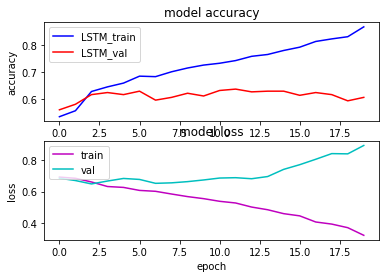

In [136]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['acc'], c= 'b')
at.plot(history.history['val_acc'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

__Now we will train the model with the dataset containing text and its features__

__Encoding text__

We will encode our text data using TF-IDF. We first fit transform on our train and test set’s CLEAN_TEXT column and then merge it with all features columns.
As we have seen TF-IDF was performing good compared to CountVectorizer, going forward we will be using TF-IDF for vectorizing the text.

In [137]:
vectorizer_fe = TfidfVectorizer()
tf_idf_features = vectorizer_fe.fit_transform(df_fe['CLEAN_TEXT']).toarray()

In [138]:
#Converting above tf_idf_features to DataFrame
tf_idf = pd.DataFrame(tf_idf_features)

In [139]:
df_fe.columns

Index(['BLOG', 'GENDER', 'TOKENS', 'CLEAN_TEXT', 'char_count', 'word_count',
       'word_density', 'unique_word_count', 'stopword_count', 'avg_wordlength',
       'unique_vs_words', 'stopwords_vs_words', 'polarity', 'subjectivity'],
      dtype='object')

In [140]:
#Listing all features
features = ['char_count', 'word_count',
       'word_density', 'unique_word_count', 'stopword_count', 'avg_wordlength',
       'unique_vs_words', 'stopwords_vs_words']

In [141]:
#Finally merging all features with above TF-IDF. 
merge_df = pd.merge(tf_idf,df_fe[features],left_index=True, right_index=True)

In [142]:
merge_df

,0,1,2,3,4,5,6,7,8,9,...,53946,53947,char_count,word_count,word_density,unique_word_count,stopword_count,avg_wordlength,unique_vs_words,stopwords_vs_words
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1512,203,7.411765,190,0,7.448276,0.935961,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,549,77,7.038462,73,1,7.129870,0.948052,0.012987
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,358,50,7.019608,48,1,7.160000,0.960000,0.020000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,270,37,7.105263,37,0,7.297297,1.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,452,60,7.409836,59,1,7.533333,0.983333,0.016667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1469,192,7.611399,184,0,7.651042,0.958333,0.000000
2595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,173,25,6.653846,25,0,6.920000,1.000000,0.000000
2596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,504,76,6.545455,72,0,6.631579,0.947368,0.000000
2597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,134,22,5.826087,22,0,6.090909,1.000000,0.000000


In [143]:
def my_models(feature,target):
    
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=seed)
    model_prediction = dict()
    
    #Multinomial Naive Bayes
    model = MultinomialNB().fit(X_train , y_train)
    model_prediction['Multinomial'] = model.predict(X_test)

    #Logistic Regression
    model = LogisticRegression(C=1).fit(X_train, y_train)
    model_prediction['Logistic'] = model.predict(X_test)

    #SVM - Support Vector Classifier
    model = SVC(gamma='auto', C=1).fit(X_train, y_train)
    model_prediction['SVM'] = model.predict(X_test)

    #Decision Trees
    model = DecisionTreeClassifier().fit(X_train, y_train)
    model_prediction['Decision Tree'] = model.predict(X_test)

    #Random Forest
    model = RandomForestClassifier().fit(X_train, y_train)
    model_prediction['Random Forest'] = model.predict(X_test)

    #Adaboost
    model = AdaBoostClassifier().fit(X_train, y_train)
    model_prediction['Adaboost'] = model.predict(X_test)
    
    print("ACCURACY SCORE:\n")
    for model_name in model_prediction.keys():
        print(model_name, ': ', round(accuracy_score(y_test, model_prediction[model_name])*100, 2))
    
    print("\n")
    print("F1 SCORE:\n")
    for model_name in model_prediction.keys():
        print(model_name, ': ', round(f1_score(y_test, model_prediction[model_name]), 2))
        
    
    print("\n")
    count = 0
    colors = ['b', 'g', 'y', 'm', 'k', 'c']
    for model, prediction in model_prediction.items():
        fpr, tpr, threshold = roc_curve(y_test, prediction)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, colors[count], label='%s: AUC %0.2f'% (model, roc_auc))
        count += 1

    plt.title('ROC-AUC Comparision')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

ACCURACY SCORE:

Multinomial :  55.77
Logistic :  58.85
SVM :  50.58
Decision Tree :  57.69
Random Forest :  67.69
Adaboost :  59.81


F1 SCORE:

Multinomial :  0.42
Logistic :  0.64
SVM :  0.56
Decision Tree :  0.56
Random Forest :  0.67
Adaboost :  0.6




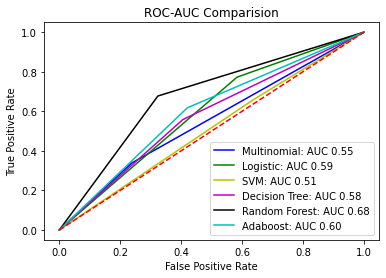

In [144]:
X = merge_df
y = df["GENDER"]
my_models(X,y)

__Observation__

- __Using textual features, we could find that Random Forest was performing well compared to other algorithms__

__Now we will train the model with the dataset containing text and its POS tagging features__

In [145]:
df_pos.columns

Index(['BLOG', 'GENDER', 'TOKENS', 'CLEAN_TEXT', 'noun_count', 'verb_count',
       'adj_count', 'adv_count', 'pron_count'],
      dtype='object')

In [146]:
#Listing all features
features = ['noun_count', 'verb_count',
       'adj_count', 'adv_count', 'pron_count']

#Finally merging all POS features with above TF-IDF. 
merge_df_pos = pd.merge(tf_idf,df_pos[features],left_index=True, right_index=True)

In [147]:
merge_df_pos.head()

,0,1,2,3,4,5,6,7,8,9,...,53943,53944,53945,53946,53947,noun_count,verb_count,adj_count,adv_count,pron_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,106,46,41,8,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,34,21,19,2,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,29,8,12,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22,8,6,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23,19,14,3,0


ACCURACY SCORE:

Multinomial :  57.69
Logistic :  70.0
SVM :  49.23
Decision Tree :  57.12
Random Forest :  66.15
Adaboost :  64.42


F1 SCORE:

Multinomial :  0.28
Logistic :  0.7
SVM :  0.62
Decision Tree :  0.56
Random Forest :  0.66
Adaboost :  0.61




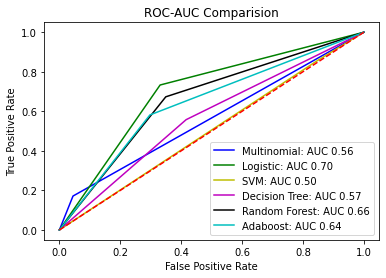

In [148]:
X = merge_df_pos
y = df["GENDER"]
my_models(X,y)

__Observation__

- __Using POS features, we could find that logistic regression was performing well compared to other algorithms__ 

__Deployment__

In [166]:
X = df["CLEAN_TEXT"]
y = df["GENDER"]
#Extract feature using TFIDF vectorization
tfvec = TfidfVectorizer()
X = tfvec.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
#Naive Bayes Classifier  
clf = MultinomialNB() 
clf.fit(X_train,y_train) 
print(clf.score(X_test,y_test)) 
#Saving the model
joblib.dump(clf, 'NB_blog_model.pkl') 
joblib.dump(tfvec, 'tfvec.pkl')

0.6884615384615385


['tfvec.pkl']

Notice here that we have saved the Naive Bayes’ model and the tfidf vectorizer as well. This is because for the text input which will be taken from user, will have to be vectorized using the same tfidf Vectorizer parameters as the model was trained on.

In [167]:
from flask import Flask, render_template, request

Here, Flask will be used to define the app which we are using. Then render_template will render the home page (home.html) and the prediction page (result.html). And the request will be used to retrieve the text input which will be sent to the flask app via the HTML Post method from the HTML page.

Now we need to define the flask app and its default routing to the home page, which is home.html. We will define a function will do nothing but render the home page when the application URL is called.

In [168]:
#!pip install flask
app = Flask(__name__) 

@app.route('/') #Routes the app to below task when the URL is called 

def home(): 

    return render_template('home.html')

Now comes the main part of the app, the prediction. We need to define a function that opens and loads the NLP model and  Vectorizer pickle files. It then retrieves the text input which is sent to it via the POST method. The retrieved text input is then vectorized using the same vectorizer and dumped to our model to get the prediction. That’s it! We now just need to render this prediction result back on the prediction page and we’re done.

In [169]:
def predict_gender(): 

    NB_blog_model = open('NB_blog_model.pkl','rb') 
    clf = joblib.load(NB_blog_model)

    tf_model = open('tfvec.pkl', 'rb')
    tf = joblib.load(tf_model)

    if request.method == 'POST': 

        message = request.form['message'] 
        data = [message] 
        vect = tf.transform(data).toarray()
        my_prediction = clf.predict(vect) 

    return render_template('result.html',prediction = my_prediction)   

#Calling the main function and running the flask app 

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1